# Collate Word Counts

In [1]:
from pathlib import Path

import matplotlib
import pandas as pd

In [2]:
data_dir = Path("../data")
assert data_dir.exists()

In [20]:
dfs = []
for source, fname in zip(
    ["Wikipedia", "Project Gutenberg", "peS2o"],
    ["wiki_word_counts.csv", "books_word_counts.csv", "s2_word_counts.csv"],
):
    df = pd.read_csv(
        data_dir / "derived" / fname, header=None, names=["count", "word"], dtype={"count": int, "word": str}
    )
    df["source"] = source
    dfs.append(df)
len(dfs)

3

In [21]:
dfs[2].head(10)

,count,word,source
0,13104,Response,peS2o
1,36987140,of,peS2o
2,89,jujube,peS2o
3,18527,fruits,peS2o
4,19039849,to,peS2o
5,18057,exogenous,peS2o
6,962,oxalic,peS2o
7,249218,acid,peS2o
8,686752,treatment,peS2o
9,700098,based,peS2o


In [105]:
top_n = 1000
top_dfs = []
for df in dfs:
    df = df.sort_values(by="count", ascending=False)
    df = df[(df["word"] != "") & (df["word"].notna())]
    total_words = df["count"].sum()
    source = df["source"].iloc[0]
    print(f"{source} total words: {total_words}")
    print(f"{source} unique words: {len(df)}")
    print(f"{source} % hapaxes: {(df['count'] == 1).sum() / len(df):.1%}")
    df = df.head(1000000).copy()
    df = df.reset_index(drop=True)
    df["rank"] = df.index + 1
    df["pct"] = df["count"] / total_words
    top_word_count = df["count"].iloc[0]
    df["zipf"] = df["count"] / top_word_count
    top_dfs.append(df)
len(top_dfs)

Wikipedia total words: 2569550145
Wikipedia unique words: 12931993
Wikipedia % hapaxes: 54.7%
Project Gutenberg total words: 3174282374
Project Gutenberg unique words: 14325897
Project Gutenberg % hapaxes: 62.2%
peS2o total words: 971899439
peS2o unique words: 4915017
peS2o % hapaxes: 23.2%


3

In [62]:
pd.DataFrame(
    {
        "Source": ["peS2o", "Project Gutenberg", "Wikipedia"],
        "GPT-NeoX Tokens (billions)": ["57", "4.8", "3.6"],
        "This word count (billions)": ["-", "3.53", "2.59"],
        "Unique words (millions)": ["-", "14.3", "12.9"],
        "% Hapaxes": ["23.2%", "62.2%", "54.7%"],
    }
)

,Source,GPT-NeoX Tokens (billions),This word count (billions),Unique words (millions),% Hapaxes
0,peS2o,57,-,-,23.2%
1,Project Gutenberg,4.8,3.53,14.3,62.2%
2,Wikipedia,3.6,2.59,12.9,54.7%


In [106]:
top_dfs[2].head(10)

,count,word,source,rank,pct,zipf
0,57425445,the,peS2o,1,0.059086,1.000000
1,36987140,of,peS2o,2,0.038057,0.644090
2,28712503,and,peS2o,3,0.029543,0.499996
3,20797356,in,peS2o,4,0.021399,0.362163
4,19039849,to,peS2o,5,0.019590,0.331558
5,15170079,a,peS2o,6,0.015609,0.264170
6,11925900,is,peS2o,7,0.012271,0.207676
7,9286966,for,peS2o,8,0.009555,0.161722
8,8947168,with,peS2o,9,0.009206,0.155805
9,8560627,that,peS2o,10,0.008808,0.149074


In [112]:
top_n = 500
cols = ["word", "pct", "rank"]
mdf = pd.merge(
    pd.merge(top_dfs[0][cols], top_dfs[1][cols], how="outer", on="word", suffixes=("_wiki", "_gutenberg")),
    top_dfs[2][cols].rename(columns={"pct": "pct_s2", "rank": "rank_s2"}),
    how="outer",
    on="word",
)  # .fillna("-")
mdf = mdf[(mdf.rank_wiki <= top_n) | (mdf.rank_gutenberg <= top_n) | (mdf.rank_s2 <= top_n)].copy()

mdf["Mean Rank"] = mdf[["rank_wiki", "rank_gutenberg", "rank_s2"]].fillna(1000001).mean(axis=1)
# mdf["Mean Rank"] = mdf["Mean Rank"].map(lambda v: f"{v:.2f}")

for column in mdf.columns:
    # if column.startswith("pct"):
    #    mdf[column] = mdf[column].map(lambda v: (f"{v:.5f}" if pd.notna(v) else "-")
    if column.startswith("rank"):
        mdf[column] = mdf[column].map(lambda v: int(v) if pd.notna(v) else 1001)

mdf = mdf[["word", "Mean Rank", "rank_s2", "pct_s2", "rank_gutenberg", "pct_gutenberg", "rank_wiki", "pct_wiki"]]


def pretty_col_name(column):
    name, source = column.split("_")
    if name == "pct":
        name = "P(w)"
    elif name == "rank":
        name = "Rank"
    if source == "wiki":
        source = "Wikipedia"
    elif source == "gutenberg":
        source = "Gutenberg"
    elif source == "s2":
        source = "peS2o"
    return f"{source} {name}"


mdf = mdf.rename(
    columns={column: pretty_col_name(column) if "_" in column else column for column in mdf.columns}
).rename(
    columns={
        "word": "Word",
    }
)
mdf = mdf.sort_values(by=["Mean Rank", "Wikipedia Rank", "Gutenberg Rank"], ascending=True).reset_index(drop=True)
mdf  # .head(20)

,Word,Mean Rank,peS2o Rank,peS2o P(w),Gutenberg Rank,Gutenberg P(w),Wikipedia Rank,Wikipedia P(w)
0,the,1.000000,1,5.908579e-02,1,6.033402e-02,1,6.253678e-02
1,of,2.000000,2,3.805655e-02,2,3.578621e-02,2,3.411199e-02
2,and,3.000000,3,2.954267e-02,3,3.036963e-02,3,2.959591e-02
3,in,4.666667,4,2.139867e-02,6,1.718741e-02,4,2.559779e-02
4,to,4.666667,5,1.959035e-02,4,2.574570e-02,5,2.075563e-02
...,...,...,...,...,...,...,...,...
1002,sir,55374.333333,116162,1.471346e-07,493,1.887995e-04,49468,7.561635e-07
1003,algorithm,73239.666667,388,2.777036e-04,213391,4.189923e-08,5940,1.669281e-05
1004,µ,92365.666667,494,2.255655e-04,79771,2.249327e-07,196832,8.561810e-08
1005,CHAPTER,99115.666667,96237,1.954935e-07,473,1.975420e-04,200637,8.328306e-08


In [113]:
mdf.head(20)

,Word,Mean Rank,peS2o Rank,peS2o P(w),Gutenberg Rank,Gutenberg P(w),Wikipedia Rank,Wikipedia P(w)
0,the,1.000000,1,0.059086,1,0.060334,1,0.062537
1,of,2.000000,2,0.038057,2,0.035786,2,0.034112
2,and,3.000000,3,0.029543,3,0.030370,3,0.029596
3,in,4.666667,4,0.021399,6,0.017187,4,0.025598
4,to,4.666667,5,0.019590,4,0.025746,5,0.020756
5,a,5.666667,6,0.015609,5,0.019530,6,0.020071
6,is,9.000000,7,0.012271,11,0.008102,9,0.009507
7,was,9.666667,14,0.005832,8,0.010475,7,0.012864
8,that,10.666667,10,0.008808,7,0.011018,15,0.005861
9,for,11.333333,8,0.009555,16,0.007056,10,0.008299


In [114]:
mdf.to_csv("../src/resources/top_words.csv", index=False)

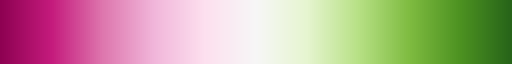

In [115]:
matplotlib.cm.PiYG